In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.losses import CategoricalCrossentropy # Import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Use the direct path of the file in your Drive
import pandas as pd
file_path = "/content/drive/My Drive/Reviews.csv"
file_path1="/content/drive/My Drive/glove.6B.100d.txt"
df=pd.read_csv(file_path)
df.head()


Mounted at /content/drive


,Id,Score,Text
0,1,5,Good Quality Dog Food I have bought several of...
1,2,1,Not as Advertised Product arrived labeled as J...
2,3,4,"""Delight"" says it all This is a confection tha..."
3,4,2,Cough Medicine If you are looking for the secr...
4,5,5,Great taffy Great taffy at a great price. The...


Epoch 1/10
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 254s 68ms/step - accuracy: 0.8071 - f1_score: 0.5880 - loss: 0.6417 - precision: 0.8747 - recall: 0.7269 - val_accuracy: 0.8459 - val_f1_score: 0.6858 - val_loss: 0.4933 - val_precision: 0.8748 - val_recall: 0.8172 - learning_rate: 0.0010
Epoch 2/10
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 242s 68ms/step - accuracy: 0.8641 - f1_score: 0.7135 - loss: 0.4896 - precision: 0.8932 - recall: 0.8369 - val_accuracy: 0.8563 - val_f1_score: 0.7024 - val_loss: 0.4605 - val_precision: 0.8814 - val_recall: 0.8275 - learning_rate: 0.0010
Epoch 3/10
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 243s 68ms/step - accuracy: 0.8765 - f1_score: 0.7386 - loss: 0.4584 - precision: 0.8968 - recall: 0.8571 - val_accuracy: 0.8745 - val_f1_score: 0.7175 - val_loss: 0.4358 - val_precision: 0.8964 - val_recall: 0.8522 - learning_rate: 0.0010
Epoch 4/10
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 241s 68ms/step - accuracy: 0.8882 - f1_score: 0.7590 - loss: 0.4314 - precision: 0.9047 - recall: 0.8723 - val_accu

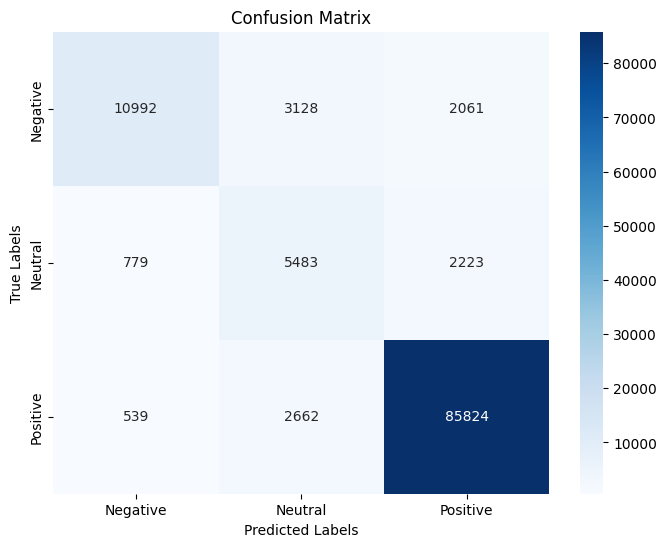


Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.68      0.77     16181
     Neutral       0.49      0.65      0.56      8485
    Positive       0.95      0.96      0.96     89025

    accuracy                           0.90    113691
   macro avg       0.78      0.76      0.76    113691
weighted avg       0.91      0.90      0.90    113691

Class 'Negative' Accuracy: 0.68
Class 'Neutral' Accuracy: 0.65
Class 'Positive' Accuracy: 0.96


In [ ]:
# Parameters
VOCAB_SIZE = 30000
EMBEDDING_DIM = 100
MAX_LEN_TEXT = 150

def map_score_to_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['Sentiment'] = df['Score'].apply(map_score_to_sentiment)

# Convert the 'Text' column to strings and handle missing values
df['Text'] = df['Text'].astype(str).fillna('')  # Convert to string and replace NaNs with empty strings

# Tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Text'].tolist())

text_seq = tokenizer.texts_to_sequences(df['Text'])
X_text = pad_sequences(text_seq, maxlen=MAX_LEN_TEXT, padding='post', truncating='post')
y = to_categorical(df['Sentiment'], num_classes=3)

# Load GloVe embeddings
embedding_index = {}
with open(file_path1, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

word_index = tokenizer.word_index
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Train-Validation Split
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# Manually Tuned Class Weights
class_weight_dict = {
    0: 1.0,  # Negative
    1: 3.0,  # Neutral
    2: 0.7   # Positive
}

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

# Model Architecture
text_input = Input(shape=(MAX_LEN_TEXT,))
embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)
text_emb = embedding_layer(text_input)

text_enc = Bidirectional(LSTM(64, return_sequences=True))(text_emb)
text_enc = transformer_encoder(text_enc, head_size=EMBEDDING_DIM//4, num_heads=4, ff_dim=128, dropout=0.2)
text_enc = transformer_encoder(text_enc, head_size=EMBEDDING_DIM//4, num_heads=4, ff_dim=128, dropout=0.2)
text_enc = GlobalAveragePooling1D()(text_enc)

x = Dense(128, activation='relu')(text_enc)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
sentiment_output = Dense(3, activation='softmax')(x)

model = Model(inputs=text_input, outputs=sentiment_output)

# Compile & Train with Label Smoothing
loss_fn = CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy', Precision(), Recall(), F1Score()])

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)
]

history=model.fit(
    X_train_text, y_train,
    validation_data=(X_val_text, y_val),
    epochs=10,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Evaluation
y_pred = model.predict(X_val_text)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Negative', 'Neutral', 'Positive']))

# Per-class Accuracy
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"Class '{label}' Accuracy: {class_accuracy[i]:.2f}")


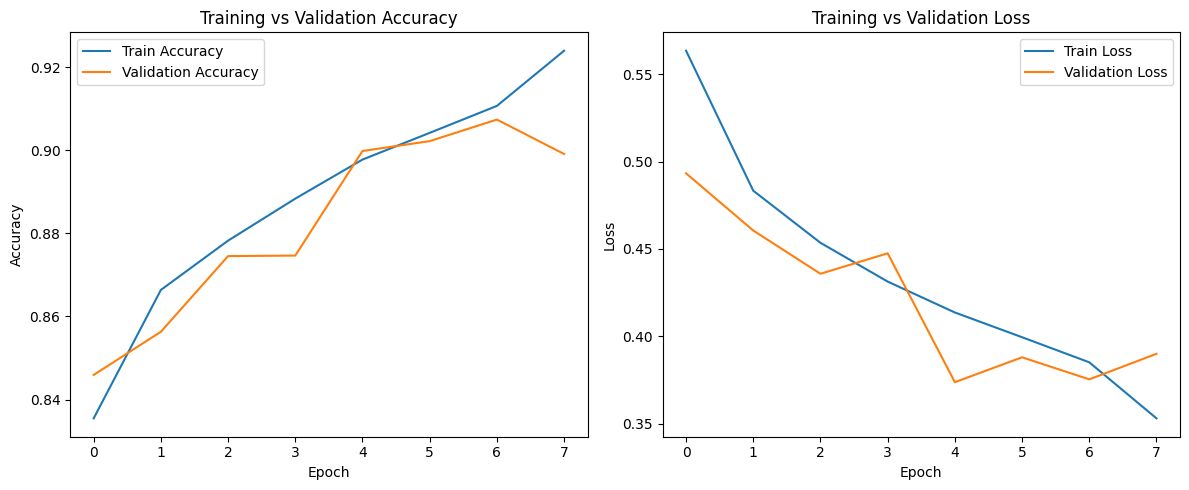

In [ ]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Class 0 (('Negative', 'Neutral', 'Positive')[i]):
  AUC: 0.9761
Class 1 (('Negative', 'Neutral', 'Positive')[i]):
  AUC: 0.9310
Class 2 (('Negative', 'Neutral', 'Positive')[i]):
  AUC: 0.9756


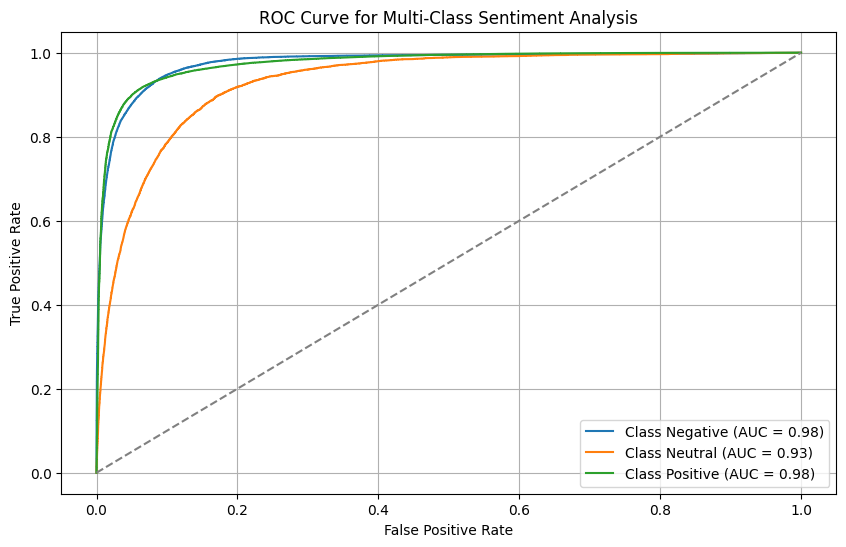

Matthews Correlation Coefficient (MCC): 0.7209


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for ROC curve calculation
y_true_binarized = label_binarize(y_true_labels, classes=[0, 1, 2])  # 0=Negative, 1=Neutral, 2=Positive

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # Number of classes
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Print AUC and ROC scores for each class
    print(f"Class {i} ({'Negative', 'Neutral', 'Positive'}[i]):")
    print(f"  AUC: {roc_auc[i]:.4f}")
    # Print ROC points (FPR, TPR): {list(zip(fpr[i], tpr[i]))}") # Removed printing the list of points

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve for Multi-Class Sentiment Analysis")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
from sklearn.metrics import matthews_corrcoef

# Compute MCC
mcc = matthews_corrcoef(y_true_labels, y_pred_labels)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

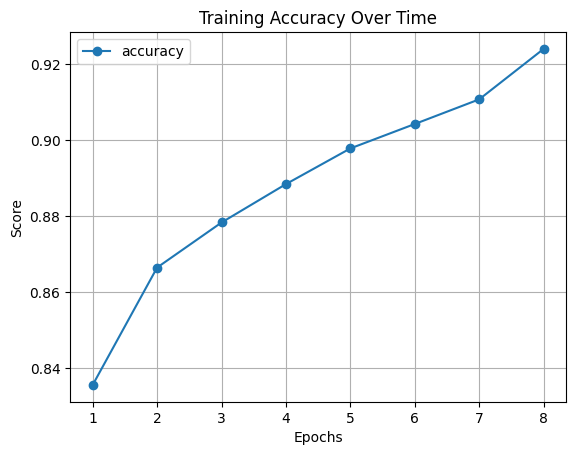

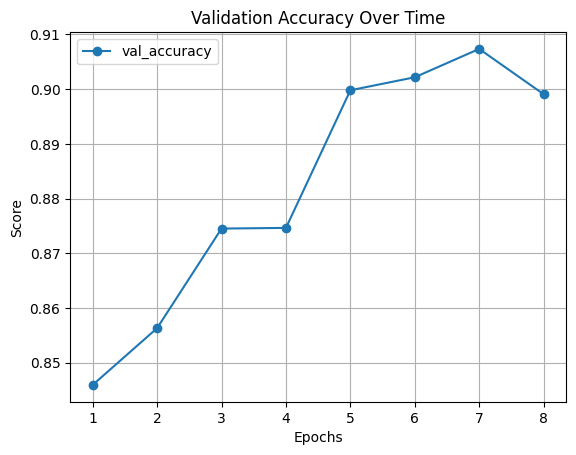

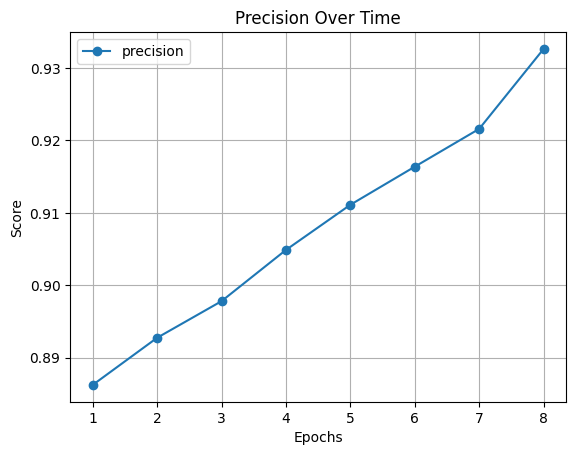

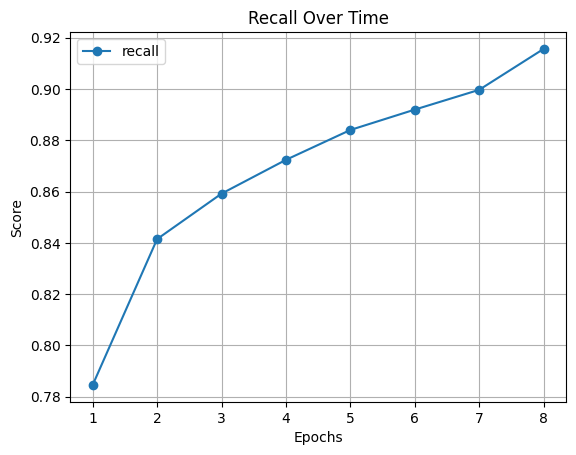

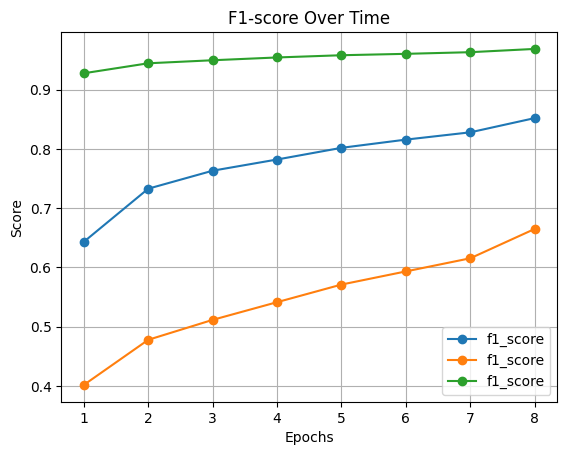

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Get accuracy values from history
iterations = list(range(1, len(history.history['accuracy']) + 1))  # Epochs as iterations
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting function
def plot_metric(metric_values, title, label):
    plt.figure()
    plt.plot(iterations, metric_values, marker='o', label=label)
    plt.title(f'{title} Over Time')
    plt.xlabel('Epochs')  # Changed to Epochs
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy
plot_metric(accuracy, 'Training Accuracy', 'accuracy')
plot_metric(validation_accuracy, 'Validation Accuracy', 'val_accuracy')

# Plot Precision, Recall, and F1-score
plot_metric(history.history['precision'], 'Precision', 'precision')
# plot_metric(history.history['val_precision'], 'Validation Precision', 'val_precision')
plot_metric(history.history['recall'], 'Recall', 'recall')
# plot_metric(history.history['val_recall'], 'Validation Recall', 'val_recall')
plot_metric(history.history['f1_score'], 'F1-score', 'f1_score')
# plot_metric(history.history['val_f1_score'], 'Validation F1-score', 'val_f1_score')

In [ ]:
from google.colab import files
# Save the model to a file
model.save('sentiment_model5.h5')  # ✅ Native Keras 3 format
print("Model saved successfully.")
files.download('sentiment_model5.h5')
model.save('sentiment_model5.keras')  # ✅ Native Keras 3 format
print("Model saved successfully.")
files.download('sentiment_model5.keras')



Model saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

files.download('tokenizer.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>